<a href="https://colab.research.google.com/github/BLOOMFLARK/NN_noise_classification/blob/master/PCANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# написать функцию fit в класс PCANet, который бы обучал модель

In [0]:
import torch.nn.functional as F
from sklearn.decomposition import PCA, IncrementalPCA
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

import torch
from torchvision import transforms, models, datasets

import random


class PCANet(torch.nn.Module):
    def __init__(self, num_filters: list, filters_sizes: list, batch_size=256):
        super(PCANet, self).__init__()
        self.params = {
            'num_filters': num_filters,
            'filters_sizes': filters_sizes,
        }
        self.W_1 = None
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.act1 = torch.nn.ReLU()
        self.W_2 = None
        # self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = torch.nn.Linear(90, 10, bias=True)
        #self.fc = torch.nn.Linear(30250, 2, bias=True)
        # self.fc2 = torch.nn.Linear(100, 2, bias=True)
        self.batch_size = batch_size

    def forward(self, x):
        x = F.conv2d(x, self.W_1)
        x = self.act1(x)
        x = self.pool1(x)
        N1, C1, H1, W1 = x.shape

        x = F.conv2d(x, self.W_2)
        x = self.act1(x)
        x = self.pool1(x)
        N, C, H, W = x.shape

        x_flat = x.view(N, C * H * W)

        x_flat = self.fc(x_flat)
        # x_flat = self.act1(x_flat)
        # x_flat = self.fc2(x_flat)
        return x_flat
            
    @staticmethod        
    def _extract_image_patches(imgs: torch.Tensor, filter_size, stride=1, remove_mean=True):
        # imgs.shape = (N, C, H, W) -> (N, 1, H, W) 
        # так должно быть, но сюда могут прийти не grayscale изображения первого шага, а со второго
        # на котором применено L1 фильтров -> L1 каналов
        N, n_channels, H, W = imgs.shape
        
        if n_channels > 1:
            # изображение вида (N, C, H, W) - N C-канальных изображений
            # приводим к виду (N*C, 1, H, W) - N*C одно-канальных изображений
            imgs = imgs.view(-1, 1, H, W)
        print('images shape', imgs.shape)
            
        k = filter_size
        patches = torch.nn.functional.unfold(imgs, k, padding=k//2) # (N, k^2, H*W)
        print('patches_shape, ', patches.shape)
        print('should be patches shape, ', (imgs.shape[0], k**2, H*W))
        
        if remove_mean:
            patches -= patches.mean(dim=1, keepdim=True) # последнее измерение - количество патчей
        
        print('filter_size', k)
        X = patches.view(k**2, -1) # (k^2, N*H*W)

        return X
    
    def _convolve(self, imgs: torch.Tensor, filter_bank: torch.Tensor) -> torch.Tensor:
        weight = filter_bank
        output = F.conv2d(imgs, weight) #, padding=padding)
        return output
    
    def _first_stage(self, imgs: torch.Tensor, train: bool) -> torch.Tensor:
        # (N, C, H, W) image
        # (train_size, 1, H, W) - grayscale
        assert imgs.dim() == 4 and imgs.nelement() > 0

        print('PCANet first stage...')

        if train:
            # достаем все патчи из всех N изображений
            filter_size1 = self.params['filters_sizes'][0]
            X = self._extract_image_patches(
                imgs, filter_size1)
            
            n_filters = self.params['num_filters'][0]
            
            eigenvectors = self.get_pca_eigenvectors(X, n_components=n_filters, batch_size=self.batch_size)
            self.W_1 = torch.FloatTensor(eigenvectors).view(n_filters, 1, filter_size1, filter_size1)
         
        I = self._convolve(imgs, self.W_1)  # (N, 1, H, W) * (L1, k1, k1) -> (N, L1, H', W')
        return I
    
    @staticmethod
    def conv_output_size(w, filter_size, padding=0, stride=1):
        return int((w - filter_size + 2 * padding) / stride + 1)
    
    @staticmethod
    def get_pca_eigenvectors(X, n_components, batch_size=100):
        ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)
        print('pca fitting ...')
        ipca.fit(X @ X.t())
        eigenvectors = ipca.components_
        print('eigenvectors shape:', eigenvectors.shape)
        return eigenvectors
        
    def _second_stage(self, I: torch.Tensor, train):
        print('PCANet second stage...')
        # I: (N, L1, H, W)
        if train:
            N, L1, H, W = I.shape
            filter_size2 = self.params['filters_sizes'][1]
            n_filters2 = self.params['num_filters'][1]
            n_filters1 = self.params['num_filters'][0]
            
            H_new = self.conv_output_size(I.shape[2], filter_size2)
            W_new = self.conv_output_size(I.shape[3], filter_size2)
            
            X = self._extract_image_patches(I, filter_size2)
            print('X_SHAPE ', X.shape)
            eigenvectors = self.get_pca_eigenvectors(X, n_components=n_filters2, batch_size=self.batch_size)
            W_2 = torch.FloatTensor(eigenvectors).view(n_filters2, 1, filter_size2, filter_size2) # (L2, 1, k2, k2)
            self.W_2 = W_2.repeat(1, n_filters1, 1, 1) # (L2, L1, k2, k2) - повторяет L1 раз для конкретного l из L2
        return self._convolve(I, self.W_2)
    
    def run(self, images):
        # Создаем фильтры
        # images: (N, 1, H, W)
        I = self._first_stage(images, train=True)
        print("I ", I.shape)
        II = self._second_stage(I, train=True)
        N, C, H, W = II.shape
        # self.fc = torch.nn.Linear(H * W, 2, bias=True)
        
        

In [3]:
os.listdir()

['.config', 'drive', 'sample_data']

In [0]:
MNIST_train = datasets.MNIST('sample_data', train=True, transform=None, target_transform=None, download=True)
MNIST_test = datasets.MNIST('sample_data', train=False, transform=None, target_transform=None, download=True)


In [0]:
X_train = MNIST_train.data[:11000, :, :]
y_train = MNIST_train.targets[:11000]
X_test = MNIST_test.data[:1650, :, :]
y_test = MNIST_test.targets[:1650]

In [0]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [12]:
X_train.shape

torch.Size([11000, 1, 28, 28])

In [13]:
X_test.shape

torch.Size([1650, 1, 28, 28])

In [14]:
y_test.shape

torch.Size([1650])

In [43]:
net = PCANet([5, 10], [3, 8])
net.params

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = net.to(device)

cuda:0


In [0]:
data_root = 'drive/My Drive/dl_noise_classification/data/'
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'
class_names = ['awgn', 'bayer']

train_dir = os.path.join(data_root, train_dir)
val_dir = os.path.join(data_root, val_dir)
test_dir = os.path.join(data_root, test_dir)

train_dir

'drive/My Drive/dl_noise_classification/data/train'

In [0]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

num_epochs = 1500
batch_size = 150
lr = 1e-4

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
#optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [0]:
# МНОГО ПРОЦЕССОВ ЖРУТ ПАМЯТЬ ОЧЕНЬ МНОГО, при этом сильно не ускоряют
train_transforms = transforms.Compose([
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])


train_dataset = datasets.ImageFolder(train_dir, train_transforms)
val_dataset = datasets.ImageFolder(val_dir, val_transforms)
test_dataset = datasets.ImageFolder(test_dir, train_transforms)

train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)

all_train = torch.utils.data.DataLoader(
    train_dataset, batch_size=train_size, shuffle=False, num_workers=batch_size)

#train_dataloader = torch.utils.data.DataLoader(
#    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

#val_dataloader = torch.utils.data.DataLoader(
#    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

all_val = torch.utils.data.DataLoader(
    val_dataset, batch_size=train_size, shuffle=False, num_workers=val_size)

all_test = torch.utils.data.DataLoader(
    test_dataset, batch_size=train_size, shuffle=False, num_workers=test_size)
print("TRAIN_SIZE: {}\n VAL_SIZE: {}\nTEST_SIZE: {}".format(train_size, val_size, test_size))

TRAIN_SIZE: 900
 VAL_SIZE: 300
TEST_SIZE: 300


In [0]:
%%time
#print('all val data loading ...')
#val_data = next(iter(all_val))
print('all train data loading ...')
train_data = next(iter(all_train))
#print('test data loading')
#test_data = next(iter(all_test))

all train data loading ...
all train data loading ...
CPU times: user 243 ms, sys: 3.45 s, total: 3.7 s
Wall time: 4min 46s
CPU times: user 243 ms, sys: 3.45 s, total: 3.7 s
Wall time: 4min 46s


In [45]:
%%time

# net.run(train_data[0])
net.run(X_train)
#del train_data

PCANet first stage...
images shape torch.Size([11000, 1, 28, 28])
patches_shape,  torch.Size([11000, 9, 784])
should be patches shape,  (11000, 9, 784)
filter_size 3
pca fitting ...
eigenvectors shape: (5, 9)
I  torch.Size([11000, 5, 26, 26])
PCANet second stage...
images shape torch.Size([55000, 1, 26, 26])
patches_shape,  torch.Size([55000, 64, 729])
should be patches shape,  (55000, 64, 676)
filter_size 8
X_SHAPE  torch.Size([64, 40095000])
pca fitting ...
eigenvectors shape: (10, 64)
CPU times: user 21.6 s, sys: 107 ms, total: 21.7 s
Wall time: 13.6 s


In [0]:
%%time

print('test data loading')
test_data = next(iter(all_test))

test data loading
CPU times: user 650 ms, sys: 19.6 s, total: 20.2 s
Wall time: 2min 24s


In [0]:
%%time

print('all val data loading ...')
val_data = next(iter(all_val))

all val data loading ...
CPU times: user 714 ms, sys: 19.7 s, total: 20.4 s
Wall time: 1min 58s


In [0]:
from time import time

val_loss = np.zeros(num_epochs)
train_loss = np.zeros(num_epochs)

val_acc = np.zeros(num_epochs)
train_acc = np.zeros(num_epochs)


def train_model(model, loss, optimizer, scheduler, num_epochs):
    #print('Making filters....')
    #t_start = time()
    #model.run(train_data[0])
    #print('TIME: ', time() - t_start)


    model.W_1 = model.W_1.to(device)
    model.W_2 = model.W_2.to(device)

    for epoch in range(num_epochs):

        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #data = train_data
                data = (X_train, y_train)
                model.train()  # training mode
                history_acc = train_acc
                history_loss = train_loss
            else:
                #data = test_data
                data = (X_test, y_test)
                model.eval()   # evaluate mode (dropout + bn)
                history_acc = val_acc
                history_loss = val_loss

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # forward and backward
            with torch.set_grad_enabled(phase=='train'):
                preds = model(inputs)
                loss_value = loss(preds, labels)
                preds_class = preds.argmax(dim=1)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss_value.backward()
                    optimizer.step()

            # statistics
            running_loss += loss_value.cpu().item()
            running_acc += (preds_class.cpu() == labels.cpu().data).float().mean()
            
            epoch_loss = running_loss
            epoch_acc = running_acc
            history_acc[epoch] = epoch_acc
            history_loss[epoch] = epoch_loss

            # запоминаем модель по лоссу

            print('{} Loss: {:.4f} Acc: {:.4f}\n'.format(phase, epoch_loss, epoch_acc), flush=True)

In [52]:
%%time
train_model(net, loss, optimizer, None, num_epochs=num_epochs)

Streaming output truncated to the last 5000 lines.
val Loss: 14.0617 Acc: 0.5321

Epoch 501/1499:
train Loss: 12.2414 Acc: 0.5588

val Loss: 14.0347 Acc: 0.5333

Epoch 502/1499:
train Loss: 12.2161 Acc: 0.5592

val Loss: 14.0078 Acc: 0.5333

Epoch 503/1499:
train Loss: 12.1908 Acc: 0.5598

val Loss: 13.9810 Acc: 0.5339

Epoch 504/1499:
train Loss: 12.1656 Acc: 0.5600

val Loss: 13.9543 Acc: 0.5358

Epoch 505/1499:
train Loss: 12.1404 Acc: 0.5604

val Loss: 13.9277 Acc: 0.5370

Epoch 506/1499:
train Loss: 12.1154 Acc: 0.5605

val Loss: 13.9012 Acc: 0.5370

Epoch 507/1499:
train Loss: 12.0905 Acc: 0.5613

val Loss: 13.8748 Acc: 0.5370

Epoch 508/1499:
train Loss: 12.0656 Acc: 0.5617

val Loss: 13.8484 Acc: 0.5376

Epoch 509/1499:
train Loss: 12.0409 Acc: 0.5619

val Loss: 13.8222 Acc: 0.5376

Epoch 510/1499:
train Loss: 12.0162 Acc: 0.5624

val Loss: 13.7961 Acc: 0.5376

Epoch 511/1499:
train Loss: 11.9916 Acc: 0.5628

val Loss: 13.7700 Acc: 0.5376

Epoch 512/1499:
train Loss: 11.9671 Ac

Text(0.5, 1.0, 'loss')

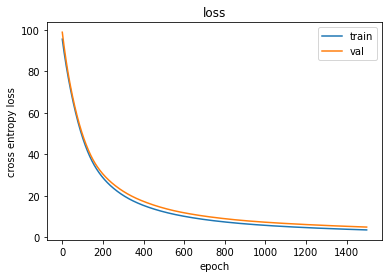

In [53]:
# Loss
plt.plot(range(num_epochs), train_loss, val_loss)
plt.legend(['train', 'val'])
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('loss')

Text(0.5, 1.0, 'accuracy')

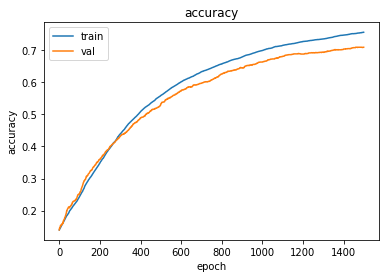

In [54]:
# accuracy
plt.plot(range(num_epochs), train_acc, val_acc)
plt.legend(['train', 'val'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy')